In [1]:
import jax
from jax import jit, random
import jax.numpy as jnp
import vpsto.vptraj_jax as jvptraj
from evosax import CMA_ES
import numpy as np
from functools import partial
from matplotlib import pyplot as plt
from vpsto.obf import OBF

%reload_ext autoreload
%autoreload 2

In [2]:
q0 = np.array([-.5, -.5]) # Initial position
qg = np.array([.5, .5]) # Goal position
dq0 = np.array([0, 0]) # Initial velocity
dqg = np.array([0, 0]) # Goal velocity

robot_radius = 0.1 # Radius of robot

bounds = 0.8*np.array([[-1, 1], [-1, 1]]) # Bounds on position

N_via = 4 # Number of via points
N_candidates = 100 # Number of candidates to sample
N_eval = 100 # Number of pos,vel,acc samples to evaluate along each candidate trajectory

R = 1e0

vel_lim = 0.4 # Velocity limit (m/s in each dimension)
acc_lim = 1 # Acceleration limit (m/s^2 in each dimension)

rng = random.PRNGKey(0)

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [3]:
def batched_collision_loss_fn(T_batch, q_robot_batch, radius_robot, x_obs_batch, radius_obs):
    # T_batch, (batch_size,)
    # x_robot_batch, (batch_size, N_eval, 2)
    # x_obs_batch, (num_obstacles, 4)
    # Predict the obstacle positions for the given horizons
    batch_size, N_eval, ndof = q_robot_batch.shape
    num_obstacles, _ = x_obs_batch.shape
    t_horizon = jnp.linspace(0, T_batch, N_eval).T # (batch_size, N_eval)
    t_horizon = jnp.repeat(t_horizon[:, :, None], ndof, axis=-1) # (batch_size, N_eval, ndof)
    t_horizon = jnp.repeat(t_horizon[None, :, :, :], num_obstacles, axis=0) # (num_obstacles, batch_size, N_eval, ndof)
    x_obs_batch = x_obs_batch[:, None, None, :] # (num_obstacles, 1, 1, 2*ndof)
    x_obs_batch = jnp.repeat(x_obs_batch, batch_size, axis=1) # (num_obstacles, batch_size, 1, 2*ndof)
    x_obs_batch = jnp.repeat(x_obs_batch, N_eval, axis=2) # (num_obstacles, batch_size, N_eval, 2*ndof)
    q_obs_batch = x_obs_batch[:, :, :, :ndof] + x_obs_batch[:, :, :, ndof:] * t_horizon # (num_obstacles, batch_size, N_eval, ndof)
    dist_sq = jnp.sum((q_robot_batch - q_obs_batch)**2, axis=-1) # (num_obstacles, batch_size, N_eval)
    return jnp.sum(dist_sq < (radius_robot + radius_obs + 0.01)**2, axis=(0, 2)) # (batch_size,)

def batched_target_loss_fn(q_robot_batch, qg):
    # q_robot_batch, (batch_size, N_eval, 2)
    # qg, (2,)
    return jnp.sum((q_robot_batch[:, -1, :] - qg)**2, axis=-1) # (batch_size,)

def batched_limit_loss_fn(q_robot_batch, radius_robot, bounds):
    # q_robot_batch, (batch_size, N_eval, 2)
    # bounds, (2, 2)
    return jnp.sum((q_robot_batch < bounds[:, 0] + radius_robot) | 
                   (q_robot_batch > bounds[:, 1] - radius_robot), axis=(1, 2)) # (batch_size,)

@jit
def batched_loss_fn(T_batch, q_robot_batch, radius_robot, x_obs_batch, radius_obs, qg, bounds):
    # T_batch, (batch_size,)
    # q_robot_batch, (batch_size, N_eval, 2)
    # x_obs_batch, (num_obstacles, 4)
    # qg, (2,)
    # bounds, (2, 2)
    return batched_collision_loss_fn(T_batch, q_robot_batch, radius_robot, x_obs_batch, radius_obs) * 1e6 + \
           batched_target_loss_fn(q_robot_batch, qg) * 1e3 + \
           batched_limit_loss_fn(q_robot_batch, radius_robot, bounds) * 1e3 + \
           T_batch

In [4]:
@partial(jit, static_argnums=(0,))
def fitness_fn(N_eval, p_samples, q0, dq0, dqg, x_obs, robot_radius, obstacle_radius, bounds):
    T = jvptraj.batched_get_T_velacc(p_samples, q0, dq0, dqg, vel_lim, acc_lim)
    q, dq, ddq = jvptraj.batched_get_trajectory(N_eval, p_samples, T, q0, dq0, dqg)
    loss = batched_loss_fn(T, q, robot_radius, x_obs, obstacle_radius, qg, bounds)
    return loss

In [5]:
@partial(jax.jit, static_argnums=(1,))
def run_es_loop(rng, num_steps, x_obs):
    """Run evolution ask-eval-tell loop."""
    es_params = strategy.default_params
    state = strategy.initialize(rng, es_params)

    def es_step(state_input, tmp):
        """Helper es step to lax.scan through."""
        rng, state = state_input
        rng, rng_gen = jax.random.split(rng)
        x, state = strategy.ask(rng_gen, state, es_params)
        
        ndof = q0.shape[0]
        N_eval = 100 # just used for numerical integration
        s_eval = np.linspace(0., 1., N_eval)
        obf = OBF(ndof)
        obf.setup_task(np.ones(N_via)/N_via)

        # Compute the basis functions: Phi, dPhi, ddPhi. (N_eval*ndof, (N_via+3)*ndof)
        Phi = obf.get_Phi(s_eval)
        dPhi = obf.get_dPhi(s_eval)
        ddPhi = obf.get_ddPhi(s_eval)

        ddPhi_p = ddPhi[:, ndof:-2*ndof]
        ddPhi_b = np.concatenate((ddPhi[:, :ndof],
                                ddPhi[:, -2*ndof:]), axis=1)

        P_smooth = ddPhi_p.T @ ddPhi_p * R / N_eval
        ddPhi_p_pinv = np.linalg.pinv(ddPhi_p)
        M = - ddPhi_p_pinv @ ddPhi_b
        mu_smooth = M @ np.concatenate((q0, dq0, dqg))
        
        # Compute the posterior precision and its Cholesky decomposition for fast sampling
        L_P = jnp.linalg.cholesky(P_smooth)
        p_samples = mu_smooth + jax.lax.linalg.triangular_solve(L_P, x.T, left_side=True, lower=True, transpose_a=True).T

        T = jvptraj.batched_get_T_velacc(p_samples, q0, dq0, dqg, vel_lim, acc_lim)
        q, dq, ddq = jvptraj.batched_get_trajectory(N_eval, p_samples, T, q0, dq0, dqg)
        loss = batched_loss_fn(T, q, robot_radius, x_obs, obstacle_radius, qg, bounds)
        state = strategy.tell(x, loss, state, es_params)
        return [rng, state], loss[jnp.argmin(loss)]

    [rng, state], scan_out = jax.lax.scan(es_step,
                               [rng, state],
                               [jnp.zeros(num_steps)])
    return state.best_member, state.best_fitness, jnp.min(scan_out)

In [6]:
# Instantiate the search strategy
strategy = CMA_ES(popsize=N_candidates, num_dims=2*N_via, elite_ratio=0.5)
es_params = strategy.default_params
state = strategy.initialize(rng, es_params)

num_generations = 100

In [10]:
# Initialize obstacles at random positions and velocities
num_obstacles = 10
obstacle_radius = 0.1
x_obs = []
for i in range(num_obstacles):
    valid = False
    while not valid:
        pos = np.random.uniform(bounds[:, 0] + obstacle_radius, bounds[:, 1] - obstacle_radius)
        vel = np.zeros(2) #np.random.uniform(-.1, .1, size=2)
        if np.linalg.norm(pos - q0) > robot_radius + obstacle_radius + 0.01:
            valid = True
    x_obs.append(np.concatenate([pos, vel]))
x_obs = np.array(x_obs)

In [11]:
p_best, loss_best, loss_best_history = run_es_loop(rng, num_generations, x_obs)
print("Best loss:", loss_best)
print("Best trajectory:", p_best)

Best loss: 1940.868
Best trajectory: [ 0.4549062  -0.51239     0.5252577  -0.5149161  -0.40325335  0.43632153
 -0.6975727   4.0661564 ]


Optimal trajectory: 0.40068156


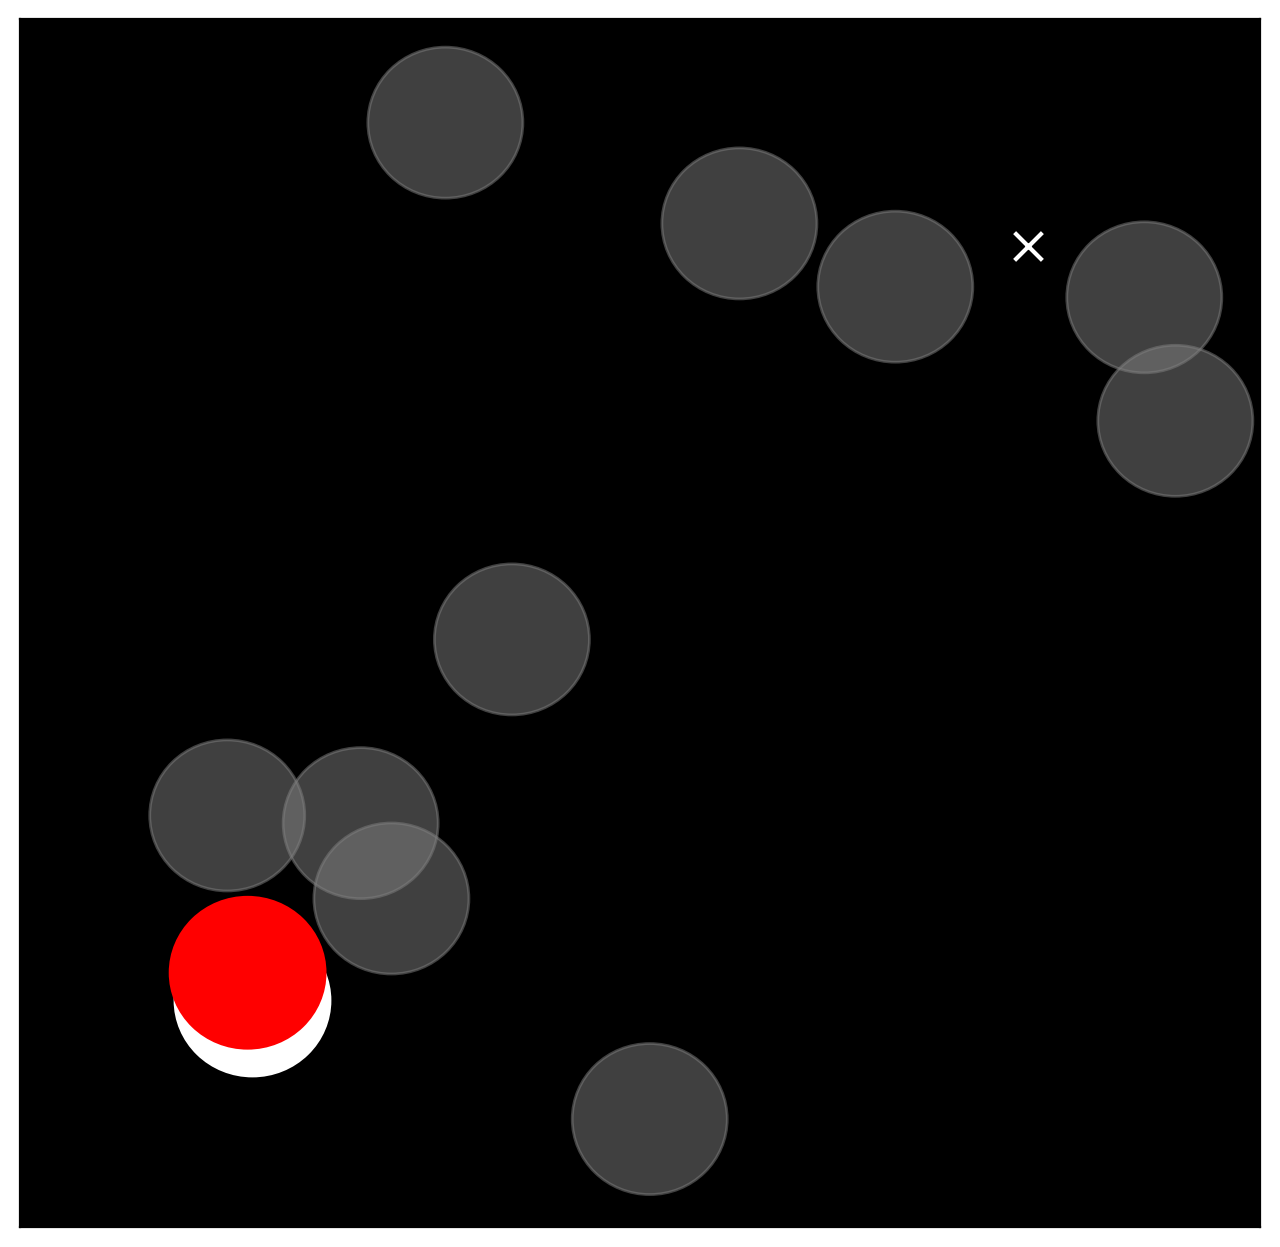

In [12]:
fig = plt.figure(figsize=(8,8), dpi=200)
ax = plt.gca()
ax.set_facecolor('k')
ax.set_xlim(bounds[0])
ax.set_ylim(bounds[1])
ax.set_xticks([])
ax.set_yticks([])

for x in x_obs:
    ax.add_patch(plt.Circle(x[:2], obstacle_radius, color='gray', alpha=.5))
ax.add_patch(plt.Circle(q0, robot_radius, color='w', label='Robot'))
plt.scatter(qg[0], qg[1], c='w', marker='x', s=100, label='Goal')

ndof = q0.shape[0]
N_eval = 100 # just used for numerical integration
s_eval = np.linspace(0., 1., N_eval)
obf = OBF(ndof)
obf.setup_task(np.ones(N_via)/N_via)

# Compute the basis functions: Phi, dPhi, ddPhi. (N_eval*ndof, (N_via+3)*ndof)
Phi = obf.get_Phi(s_eval)
dPhi = obf.get_dPhi(s_eval)
ddPhi = obf.get_ddPhi(s_eval)

ddPhi_p = ddPhi[:, ndof:-2*ndof]
ddPhi_b = np.concatenate((ddPhi[:, :ndof],
                        ddPhi[:, -2*ndof:]), axis=1)

P_smooth = ddPhi_p.T @ ddPhi_p * R / N_eval
ddPhi_p_pinv = np.linalg.pinv(ddPhi_p)
M = - ddPhi_p_pinv @ ddPhi_b
mu_smooth = M @ np.concatenate((q0, dq0, dqg))

# Compute the posterior precision and its Cholesky decomposition for fast sampling
L_P = np.linalg.cholesky(P_smooth)
p_opt = mu_smooth + jax.lax.linalg.triangular_solve(L_P, p_best, left_side=True, lower=True, transpose_a=True)
T_opt = jvptraj.get_T_velacc(p_opt, q0, dq0, dqg, vel_lim, acc_lim)
print("Optimal trajectory:", T_opt)
q_opt, dq_opt, ddq_opt = jvptraj.get_trajectory(N_eval, p_opt, T_opt, q0, dq0, dqg)
plt.plot(q_opt[:, 0], q_opt[:, 1], c='r', label='Optimal Trajectory')
ax.add_patch(plt.Circle(q_opt[-1], robot_radius, color='r', label='Robot'))
